# TUIA / AAII - TP2: Redes Recurrentes y Transformers - Problema 2

> *Modelo de generación de textos basados en RNN para escribir noticias falsas.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
# Data
import os
import time
import pathlib
from pathlib import Path
import numpy as np
import pickle

# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import plotly.graph_objects as go

# Lenguaje Natural
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import string

# Redes Neuronales
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
# from tensorflow.keras.models import Sequential, load_model, save_model
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.layers import LSTM

# Semillas para reproductibilidad
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Descargar recursos de nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset

El dataset proporcionado incluye 120000 artículos correspondientes a 4 categorías distintas. En este caso, la categoría no es relevante, sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.
https://www.tensorflow.org/datasets/catalog/ag_news_subset

### Descarga

In [4]:
# Cargar el dataset ag_news
df, info = tfds.load('ag_news_subset', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.LA14I7_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.LA14I7_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


### Descripción

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    full_name='ag_news_subset/1.0.0',
    description="""
    AG is a collection of more than 1 million news articles. News articles have been
    gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of
    activity. ComeToMyHead is an academic news search engine which has been running
    since July, 2004. The dataset is provided by the academic comunity for research
    purposes in data mining (clustering, classification, etc), information retrieval
    (ranking, search, etc), xml, data compression, data streaming, and any other
    non-commercial activity. For more information, please refer to the link
    http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .
    
    The AG's news topic classification dataset is constructed by Xiang Zhang
    (xiang.zhang@nyu.edu) from the dataset above. It is used as a text
    classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann
    LeCu

In [5]:
train_ds, val_ds = df['train'], df['test']

In [ ]:
print(f'Tamaño del conjunto de entrenamiento: {len(list(train_ds))}')
print(f'Tamaño del conjunto de validación: {len(list(val_ds))}')

Tamaño del conjunto de entrenamiento: 120000
Tamaño del conjunto de validación: 7600


In [6]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Análisis Exploratorio

Inspeccionamos el dataset el cual posee los siguientes labels:

* 0 = World
* 1 = Sports
* 2 = Business
* 3 = Sci/Tech

In [7]:
for example, label in train_ds.take(5):
  print('text: ', example.numpy().decode('utf-8'))
  print('label: ', label.numpy())
  print("-----")

text:  AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
label:  3
-----
text:  Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.
label:  1
-----
text:  President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.
label:  2
-----
text:  Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.
label:  3
-----
text:  London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.


## Concatenado del Texto

In [8]:
# Función para extraer el texto del dataset
def extract_text(data):
    texts = []
    for article, _ in data:
        texts.append(article.numpy().decode('utf-8'))
    return ' '.join(texts)

# Extraer el texto de los conjuntos de entrenamiento y prueba
train_text = extract_text(train_ds)
test_text = extract_text(val_ds)

# Unir todos los textos en uno solo
text = train_text + test_text

In [ ]:
print(f'Tamaño total del texto: {len(text)} caracteres')

Tamaño total del texto: 24798141 caracteres


In [ ]:
# Mostrar una muestra del texto
print(text[:500])

AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions. Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season. President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local


## Tokenización

In [9]:
# Tokenizar el texto en palabras y oraciones
words = word_tokenize(text)
sentences = sent_tokenize(text)

# Contar palabras y oraciones
word_count = len(words)
sentence_count = len(sentences)
unique_words = len(set(words))

print(f'Total de palabras: {word_count}')
print(f'Total de oraciones: {sentence_count}')
print(f'Palabras únicas: {unique_words}')

Total de palabras: 4576341
Total de oraciones: 143487
Palabras únicas: 107288


In [ ]:
print('Ejemplo de palabras tokenizadas:', words[100:110])
print('Ejemplo de oraciones tokenizadas:', sentences[2:4])

Ejemplo de palabras tokenizadas: ['will', 'run', 'out', 'of', 'leading', 'scientists', 'unless', 'science', 'education', 'is']
Ejemplo de oraciones tokenizadas: ['President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.', 'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.']


### Guardar / Cargar Tokens

In [ ]:
# # Guardar tokenizaciones intermedias
# with open('words.pkl', 'wb') as f:
#     pickle.dump(words, f)
# with open('sentences.pkl', 'wb') as f:
#     pickle.dump(sentences, f)

In [ ]:
# Guardar tokenizaciones intermedias
with open('words.pkl', 'rb') as f:
    words = pickle.load(f)
with open('sentences.pkl', 'rb') as f:
    sentences = pickle.load(f)

## Frecuencia de Palabras y Caracteres

In [10]:
# Frecuencia de palabras
word_freq = Counter(words)
most_common_words = word_freq.most_common(10)

# Frecuencia de caracteres
char_freq = Counter(text)
most_common_chars = char_freq.most_common(10)

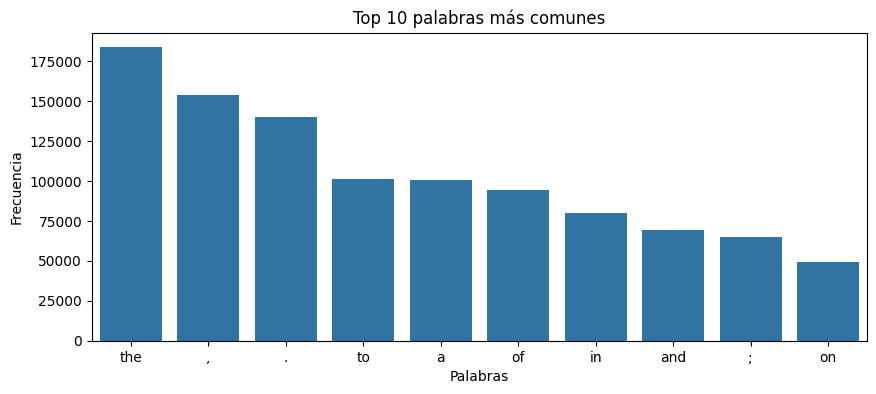

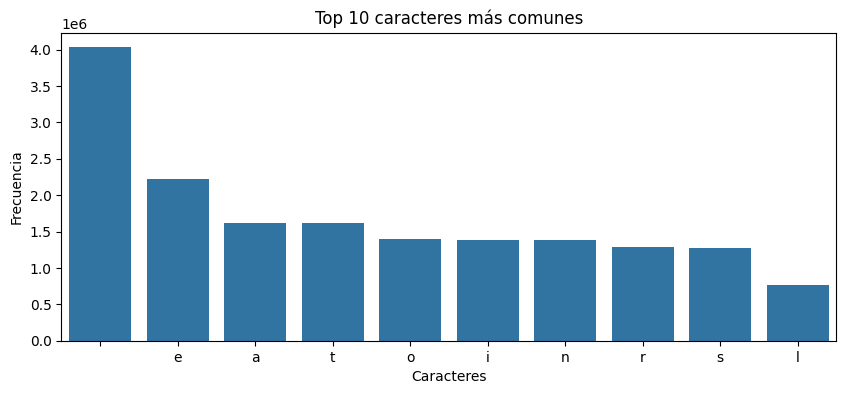

In [ ]:
# Graficar las palabras más comunes
plt.figure(figsize=(10, 4))
sns.barplot(x=[word for word, freq in most_common_words], y=[freq for word, freq in most_common_words])
plt.title('Top 10 palabras más comunes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()
print()
# Graficar los caracteres más comunes
plt.figure(figsize=(10, 4))
sns.barplot(x=[char for char, freq in most_common_chars], y=[freq for char, freq in most_common_chars])
plt.title('Top 10 caracteres más comunes')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
print('Palabras más comunes:', most_common_words)
print('Caracteres más comunes:', most_common_chars)

Palabras más comunes: [('the', 183701), (',', 153707), ('.', 140168), ('to', 101054), ('a', 100690), ('of', 94309), ('in', 80192), ('and', 69558), (';', 65177), ('on', 49283)]
Caracteres más comunes: [(' ', 4031696), ('e', 2218994), ('a', 1617452), ('t', 1614716), ('o', 1399300), ('i', 1390300), ('n', 1383800), ('r', 1285081), ('s', 1274681), ('l', 770337)]


## Longitud de Palabras y Oraciones

In [11]:
# Longitud de las palabras
word_lengths = [len(word) for word in words]

# Longitud de las oraciones
sentence_lengths = [len(sentence.split()) for sentence in sentences]

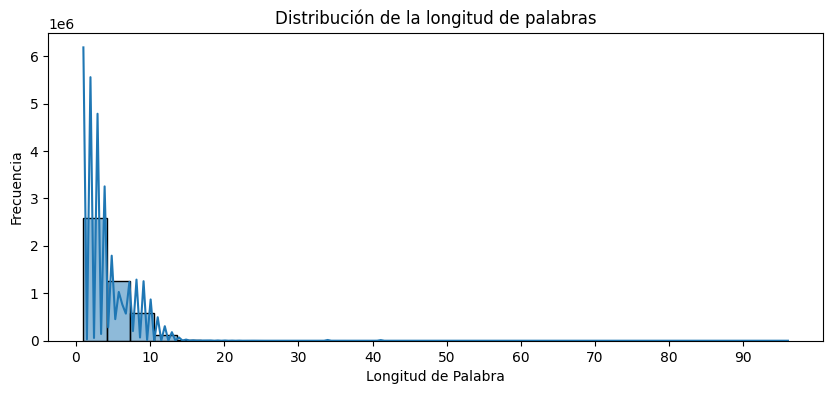

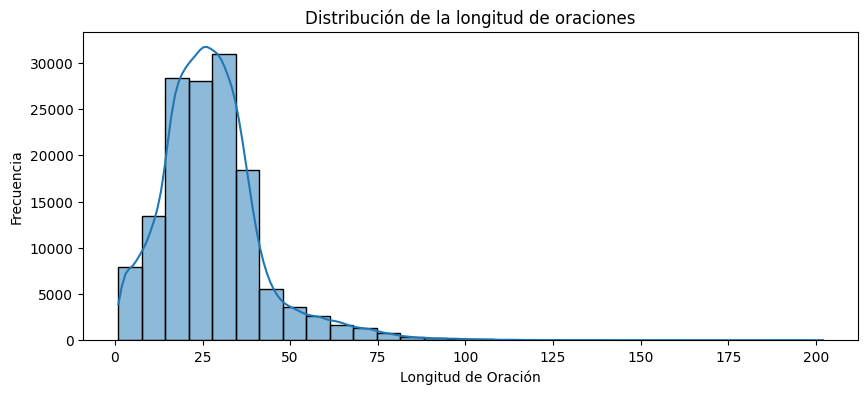

In [ ]:
# Graficar la distribución de la longitud de las palabras
plt.figure(figsize=(10, 4))
sns.histplot(word_lengths, bins=30, kde=True)
plt.xticks(range(0, 100, 10))
plt.title('Distribución de la longitud de palabras')
plt.xlabel('Longitud de Palabra')
plt.ylabel('Frecuencia')
plt.show()
print()
# Graficar la distribución de la longitud de las oraciones
plt.figure(figsize=(10, 4))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title('Distribución de la longitud de oraciones')
plt.xlabel('Longitud de Oración')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
print('Palabra de mayor longitud:', max(words, key=len))
print('Oración de mayor longitud:', max(sentences, key=len))

Palabra de mayor longitud: Funds\Municipal-Long-Term\Municipal-Medium-Term\Municipal-One-State\Municipal-Short-Term\Pacific
Oración de mayor longitud: 20-year product development veteran from Abbott Laboratories will face the challenge of completing Human Genome Sciences' makeover from gene hunter to drug marketer.&lt;br&gt;&lt;FONT face="verdana,MS Sans Serif,arial,helvetica" size="-2" color="#666666"&gt;&lt;B&gt;-The Washington Post&lt;/b&gt;&lt;/font&gt; The US Department of Homeland Security unveiled new computer workstations Thursday that allow Border Patrol agents on the Canadian and Mexican borders to tap into the FBI #39;s fingerprint database, overcoming a technological hurdle that   NEW YORK (Reuters) - U.S. blue chips closed slightly higher  on Thursday, helped by Johnson   Johnson Inc.'s &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=JNJ.N target=/stocks/quickinfo/fullquote"&gt;JNJ.N&lt;/A&gt; \$25  billion deal to buy Guidant Corp. &lt;A HREF="http://www

## Limpieza del Texto

### Mayúsculas / Minúsculas

In [12]:
# Definir una función de limpieza
def clean_text_with_length_filter(text, max_length):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar puntuaciones
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizar el texto limpio en palabras
    words = word_tokenize(text)
    # Filtrar por longitud máxima
    filtered_words = [word for word in words if len(word) < max_length]
    return filtered_words

In [13]:
# Aplicar la limpieza al texto concatenado
max_word_length = 15
cleaned_text = clean_text_with_length_filter(text, max_word_length)

# Mostrar una muestra del texto limpio
print(cleaned_text[:500])

['amd', '39s', 'new', 'dualcore', 'opteron', 'chip', 'is', 'designed', 'mainly', 'for', 'corporate', 'computing', 'applications', 'including', 'databases', 'web', 'services', 'and', 'financial', 'transactions', 'reuters', 'major', 'league', 'baseballmonday', 'announced', 'a', 'decision', 'on', 'the', 'appeal', 'filed', 'by', 'chicago', 'cubspitcher', 'kerry', 'wood', 'regarding', 'a', 'suspension', 'stemming', 'from', 'anincident', 'earlier', 'this', 'season', 'president', 'bush', '39s', 'quot', 'tax', 'reform', 'needs', 'losers', 'to', 'balance', 'its', 'winners', 'and', 'people', 'claiming', 'the', 'federal', 'deduction', 'for', 'state', 'and', 'local', 'taxes', 'may', 'be', 'in', 'administration', 'planners', '39', 'sights', 'news', 'reports', 'say', 'britain', 'will', 'run', 'out', 'of', 'leading', 'scientists', 'unless', 'science', 'education', 'is', 'improved', 'says', 'professor', 'colin', 'pillinger', 'london', 'england', 'sports', 'network', 'england', 'midfielder', 'steven', 

### Stopwords

In [14]:
# # Tokenizar el texto limpio en palabras
# cleaned_words = word_tokenize(cleaned_text)

# Filtrar stop words
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in cleaned_text if word not in stop_words]

# Mostrar una muestra de las palabras filtradas
print(filtered_words[:50])

['amd', '39s', 'new', 'dualcore', 'opteron', 'chip', 'designed', 'mainly', 'corporate', 'computing', 'applications', 'including', 'databases', 'web', 'services', 'financial', 'transactions', 'reuters', 'major', 'league', 'baseballmonday', 'announced', 'decision', 'appeal', 'filed', 'chicago', 'cubspitcher', 'kerry', 'wood', 'regarding', 'suspension', 'stemming', 'anincident', 'earlier', 'season', 'president', 'bush', '39s', 'quot', 'tax', 'reform', 'needs', 'losers', 'balance', 'winners', 'people', 'claiming', 'federal', 'deduction', 'state']


In [15]:
# Unir las palabras filtradas en un solo texto para el conteo de caracteres
cleaned_text_for_char_count = ' '.join(filtered_words)

### Comprobaciones de Limpieza

In [16]:
# Frecuencia de palabras limpias
cleaned_word_freq = Counter(filtered_words)
cleaned_most_common_words = cleaned_word_freq.most_common(10)

# Frecuencia de caracteres limpios
cleaned_char_freq = Counter(cleaned_text_for_char_count)
cleaned_most_common_chars = cleaned_char_freq.most_common(10)

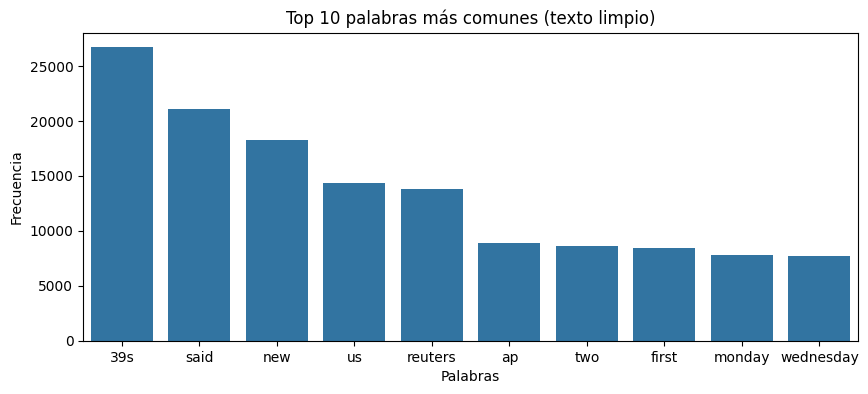

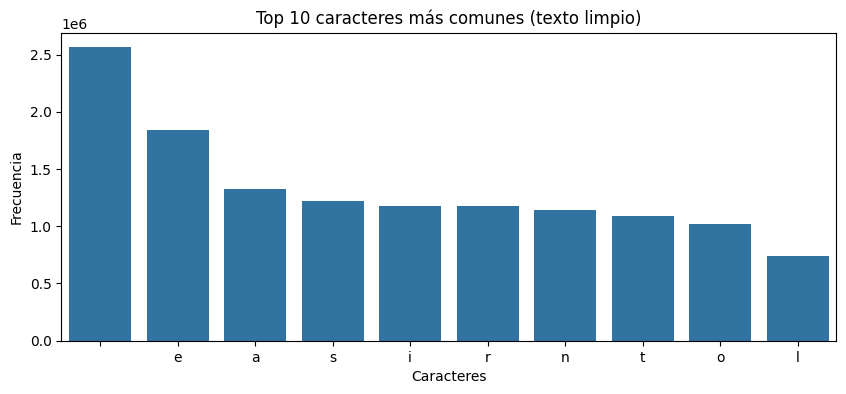

In [ ]:
# Graficar las palabras más comunes
plt.figure(figsize=(10, 4))
sns.barplot(x=[word for word, freq in cleaned_most_common_words], y=[freq for word, freq in cleaned_most_common_words])
plt.title('Top 10 palabras más comunes (texto limpio)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()
print()
# Graficar los caracteres más comunes
plt.figure(figsize=(10, 4))
sns.barplot(x=[char for char, freq in cleaned_most_common_chars], y=[freq for char, freq in cleaned_most_common_chars])
plt.title('Top 10 caracteres más comunes (texto limpio)')
plt.xlabel('Caracteres')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Encontrar la palabra de mayor longitud en texto limpio
print('Palabra de mayor longitud (texto limpio):', max(filtered_words, key=len))

Palabra de mayor longitud (texto limpio): baseballmonday


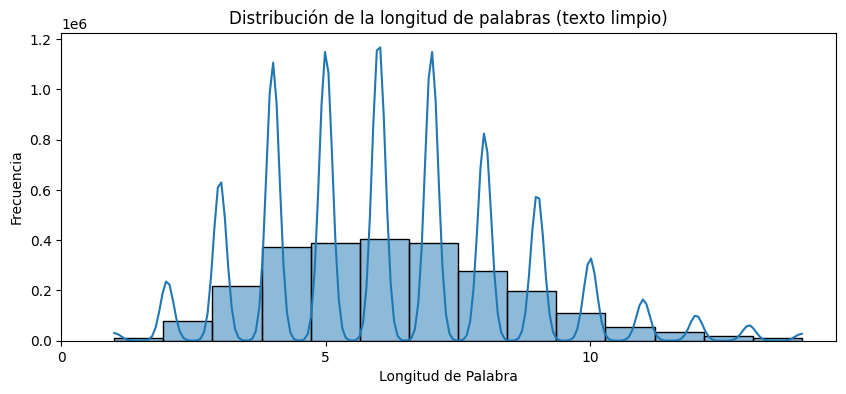

In [ ]:
# Calcular las longitudes de las palabras filtradas
word_lengths_cleaned = [len(word) for word in filtered_words]

# Graficar la distribución de la longitud de las palabras en el texto limpio
plt.figure(figsize=(10, 4))
sns.histplot(word_lengths_cleaned, bins=14, kde=True)
plt.xticks(range(0, 15, 5))
plt.title('Distribución de la longitud de palabras (texto limpio)')
plt.xlabel('Longitud de Palabra')
plt.ylabel('Frecuencia')
plt.show()

## Vocabulario

### Mapeo de caracteres e índices

In [17]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

82 unique characters


In [18]:
# Crear una capa de StringLookup para mapear caracteres a índices
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [19]:
# Convertir el texto en una secuencia de índices
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(24798141,), dtype=int64, numpy=array([29, 41, 32, ..., 71, 70, 13])>

In [20]:
# Crear un dataset de TensorFlow a partir de la secuencia de índices
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [21]:
# Crear una capa de StringLookup invertida para mapear índices a caracteres
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [22]:
# Imprimir los primeros 15 caracteres mapeados de vuelta desde índices
for ids in ids_dataset.take(15):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

A
M
D
 
#
3
9
;
s
 
n
e
w
 
d


### Secuencias de longitud fija

In [23]:
seq_length = 100

In [24]:
# Crear secuencias de longitud fija a partir del dataset de índices
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'A' b'M' b'D' b' ' b'#' b'3' b'9' b';' b's' b' ' b'n' b'e' b'w' b' '
 b'd' b'u' b'a' b'l' b'-' b'c' b'o' b'r' b'e' b' ' b'O' b'p' b't' b'e'
 b'r' b'o' b'n' b' ' b'c' b'h' b'i' b'p' b' ' b'i' b's' b' ' b'd' b'e'
 b's' b'i' b'g' b'n' b'e' b'd' b' ' b'm' b'a' b'i' b'n' b'l' b'y' b' '
 b'f' b'o' b'r' b' ' b'c' b'o' b'r' b'p' b'o' b'r' b'a' b't' b'e' b' '
 b'c' b'o' b'm' b'p' b'u' b't' b'i' b'n' b'g' b' ' b'a' b'p' b'p' b'l'
 b'i' b'c' b'a' b't' b'i' b'o' b'n' b's' b',' b' ' b'i' b'n' b'c' b'l'
 b'u' b'd' b'i'], shape=(101,), dtype=string)


In [25]:
# Convierte secuencias de indices en texto
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [26]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includi'
b'ng databases, Web services, and financial transactions. Reuters - Major League Baseball\\Monday announ'
b'ced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming'
b' from an\\incident earlier this season. President Bush #39;s  quot;revenue-neutral quot; tax reform ne'
b'eds losers to balance its winners, and people claiming the federal deduction for state and local taxe'


In [27]:
# Preparación de los pares Entrada/Objetivo
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [28]:
# Aplicar la función split_input_target a cada secuencia
dataset = sequences.map(split_input_target)

In [29]:
# Mostrar un ejemplo de entrada y objetivo
for input_example, target_example in dataset.take(1):
    print("Input:", text_from_ids(input_example).numpy().decode('utf-8'))
    print("Target:", text_from_ids(target_example).numpy().decode('utf-8'))

Input: AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includ
Target: MD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, includi


# RNN / Caracter a caracter

## Modelo

### Batch y Buffer

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Hiperparámetros

In [31]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

### Definición y entrenamiento

In [32]:
# Definición del Modelo
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [33]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [34]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 83) # (batch_size, sequence_length, vocab_size)


In [35]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  21248     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  85075     
                                                                 
Total params: 4044627 (15.43 MB)
Trainable params: 4044627 (15.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [37]:
sampled_indices

array([47, 53, 43, 81, 59, 74, 39, 33,  1, 44,  0, 67, 22, 79, 16, 21, 66,
       44,  9, 55, 28,  3, 61, 29, 41, 65, 31, 74,  9, 33, 39, 73, 61, 18,
       43, 24, 55, 20, 35, 16, 43, 63, 57, 70, 54, 70, 82, 62, 13, 17, 44,
       19, 20, 53, 28,  2, 46, 18, 28, 25, 77, 76, 26, 49, 46, 14, 24, 46,
        2, 10, 69,  1, 79, 46,  9,  1, 27, 57,  6, 78, 26, 39, 13, 15, 71,
        9, 36, 71, 57, 51, 62, 62, 47, 52, 72, 69, 74, 71, 57, 16])

In [38]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b" re-claimed  his role as the Arizona Cardinals' starting quarterback, at  least temporarily. TABA, E"

Next Char Predictions:
 b'SYOycrKE P[UNK]k7w16jP)\\?"eAMiCr)EKqe3O9\\5G1OganZnzf.2P45Y?!R3?:ut;UR/9R!*m wR) =a&v;K.0o)HoaWffSXpmroa1'


### Entrenamiento

In [39]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [40]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 83)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.4185815, shape=(), dtype=float32)


In [41]:
tf.exp(example_batch_mean_loss).numpy()

82.97849

In [42]:
model.compile(optimizer='adam', loss=loss)

In [43]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [44]:
EPOCHS = 10

In [45]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
3836/3836 [==============================] - 226s 58ms/step - loss: 1.4260
Epoch 2/10
3836/3836 [==============================] - 222s 57ms/step - loss: 1.1371
Epoch 3/10
3836/3836 [==============================] - 222s 57ms/step - loss: 1.0970
Epoch 4/10
3836/3836 [==============================] - 223s 58ms/step - loss: 1.0819
Epoch 5/10
3836/3836 [==============================] - 223s 58ms/step - loss: 1.0775
Epoch 6/10
3836/3836 [==============================] - 223s 58ms/step - loss: 1.0821
Epoch 7/10
3836/3836 [==============================] - 222s 57ms/step - loss: 1.0906
Epoch 8/10
3836/3836 [==============================] - 224s 58ms/step - loss: 1.1165
Epoch 9/10
3836/3836 [==============================] - 221s 57ms/step - loss: 1.8364
Epoch 10/10
3836/3836 [==============================] - 222s 57ms/step - loss: 2.1017


In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
3836/3836 [==============================] - 232s 59ms/step - loss: 1.4206
Epoch 2/20
3836/3836 [==============================] - 229s 59ms/step - loss: 1.1372
Epoch 3/20
3836/3836 [==============================] - 229s 59ms/step - loss: 1.0972
Epoch 4/20
3836/3836 [==============================] - 229s 59ms/step - loss: 1.0822
Epoch 5/20
3836/3836 [==============================] - 229s 59ms/step - loss: 1.0783
Epoch 6/20
3836/3836 [==============================] - 230s 59ms/step - loss: 1.0824
Epoch 7/20
3836/3836 [==============================] - 230s 60ms/step - loss: 1.0921
Epoch 8/20
3836/3836 [==============================] - 229s 59ms/step - loss: 1.1265
Epoch 9/20
3836/3836 [==============================] - 229s 59ms/step - loss: 1.7696
Epoch 10/20
3836/3836 [==============================] - 227s 59ms/step - loss: 2.0314
Epoch 11/20
3836/3836 [==============================] - 227s 59ms/step - loss: 1.8992
Epoch 12/20
3836/3836 [=============================

In [46]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [47]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [50]:
start = time.time()
states = None
next_char = tf.constant(['Messi'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Messid oun acrshd yoleft agas they Smicket and the U.S natouesdo yrances thy fread tre. Then jordude enal an execued the Neway a but ba boutnonan by, wigh. het a he churel con to mendam Lilinggure-ned Proup bjo Gut bw.. KASLA Uraq. KERULALDAL, and enduting the lopled lack Sppy his lets seetinged thaent Aaving newwa gessis defy. the This heloppp:o of Prinionald #35;6 mon Cs fim porie phcues precusiCom Tis Damen menciteal sonday Unidate, hostoper an Goldam. Tr  T Ceatim, with "intayacke formetersered wew rt the as suse on higadryed hobs mout weled winsont), 'meas tamp Ench cote denavers in in som Inc. its in 10 hencovan and prans srder ag benterdor secites. Fears on Monally and poleent casmel jors. Reunaty sentmentl con as 2004, 504 in thr compleigh aceas milio Kundun, reatpore the surth the U. peter billonge, s - roumbuthe nearily coiplished werrnat anle Tuanyspecary to tho eneq ellogin the NSIND. mis of a conloras 6his adrbo sy to act. IB Dillerpine Tusince in Thigmatan etree Holld and

In [51]:
start = time.time()
states = None
next_char = tf.constant(['The Argentina', 'The Argentina', 'The Argentina', 'The Argentina', 'The Argentina'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b'The Argentinationo, Thiglayens barmer boich laday. The USRus. Brite byuchdar assong the conating mockt toos, blo lohD endefte Barters. Alday the Upran-quirpan-belp. LOND.N: Qheurchi lye Unbaling the Mupstlearguting und ind youtr 2attion of list Panndursst sond Ospored to  AP - Suset tirch) - hith Noly Cantansrapowagits Noded mensortupis tachders. Perics of hs invecreningso the warte caption,  Interdon BD. Smurtury schansoont of Un USin saliter Pally jonday we balon. AP - DAS Chafund. APpselym to reduiter Vighe rue butst the nom the codeprice of the his Namaze of ind suseateis walt Minare. Ang I shreptoned and s for of the extinfinies freale wounder pos secont of Armorining Ganc. pran Amand. B, scoo s frow actain compuit its rat mome ellro it offorter hat Reporiters ond exped the Uming thle Tudabped Phems weekn atapous ang asceutler the to amenz scomond, left BBs and intage then the were poenters with repilonman emen rochoral fise enarstionsed to thal wa plement in th cht 

### Visualización de Métricas

## Predicciones

# RNN / Palabra a palabra

# Observaciones finales

Aunque las métricas obtenidas no son del todo malas para el problema de clasificación, los resultados están lejos de ser los deseados para esta situación. Numerosas pruebas y ensayos con distintas configuraciones y arquitecturas motivaron la decisión de reemplazar esta actividad por la denominada "Problema 2b" por lo que se interrumpe la experimentación y se continúa el trabajo con el siguiente.